In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import dill as pickle
import corner
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from sklearn.model_selection import train_test_split

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import SuperSpeculator
import popsed
popsed.set_matplotlib(style='JL', usetex=True, dpi=80, fontsize=16)
from popsed import prior

In [3]:
name = 'NMF'
wave = np.load(f'./train_sed_{name}/{name.lower()}_seds/fsps.wavelength.npy')

if name == 'NMF_ZH':
    spec_dir = [
        f'./train_sed_{name}/best_emu/speculator_best_recon_model_{name}_{i_bin}.pkl' for i_bin in range(0, 5)]
    params_name = ['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh',
                   'fburst', 'tburst', 'gamma1_zh', 'gamma2_zh',
                   'dust1', 'dust2',
                   'dust_index', 'redshift', 'logm']
else:
    spec_dir = [
        f'./train_sed_{name}/best_emu/speculator_best_recon_model_{name}.emu_{i_bin}.pkl' for i_bin in range(0, 5)]
    params_name = ['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh',
                   'fburst', 'tburst', 'logzsol',
                   'dust1', 'dust2',
                   'dust_index', 'redshift', 'logm']
speculator = SuperSpeculator(
    speculators_dir=spec_dir,
    str_wbin=['.w1000_2000',
              '.w2000_3600',
              '.w3600_5500',
              '.w5500_7410',
              '.w7410_60000'],
    wavelength=wave,
    params_name=params_name,
    device='cuda', use_speclite=True)
gama_filters = ['sdss2010-{0}'.format(b) for b in 'ugriz']
speculator._calc_transmission(gama_filters)


PHOT = 'AUTO'
noise = 'gama_snr'
noise_model_dir = f'./noise_model/gama_snr_model_mag_dr3_apmatch_{PHOT}.npy'

In [4]:
X_data = np.load('./NDE/GAMA/NMF/mock_mags_dr3apmatch_noise_2.npy')[:, :5]
print('Total number of samples:', len(X_data))

Total number of samples: 100863


In [5]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [6]:
_prior_NDE = speculator.bounds.copy()

_prior_NDE[-2] = np.array([0., 0.8])
_prior_NDE[-1] = np.array([7.5, 13.])
# _prior_NDE[-4] = np.array([0., 2.])

`lr3e-4_ann7p5_30_30t` is bad

`lr3e-4_ann7p5_30` is better

`lr3e-4_ann7p5_40` is not better than 30 epoches

`lr3e-4_ann6_30` is not better than ann7p5

python deploy_nde_mock.py --multijobs=False --output_dir='./NDE/GAMA/anneal/mock/lr3e-4_ann12_40e_20t_snr30/' --seed_low=10 --seed_high=20 --num_bins=60 --num_transforms=20 --hidden_features=100 --max_lr=3e-4 --anneal_tau=12 --max_epochs=40 --anneal_coeff=30

In [7]:
nde_dir = './NDE/GAMA/anneal/mock/lr3e-4_ann12_40e_20t_snr30/'
filelist = os.listdir(nde_dir)
# nde_dir = './NDE/GAMA/anneal/mock2/lr3e-4_ann12_zscore_40e/'
# filelist += os.listdir(nde_dir)

# filelist = [file for file in filelist if 'nde_theta_best' in file]
# ind = [int(file.replace('nde_theta_best_loss_nsf_', '').strip('.pkl')) for file in filelist]


filelist = [file for file in filelist if 'nde_theta_last' in file]
ind = [int(file.replace('nde_theta_last_model_nsf_', '').strip('.pkl')) for file in filelist]

# filelist = np.array(filelist)[np.array(ind) > 10]

# filelist = np.array(filelist)[(np.array(ind) > 30)]
# filelist = ['nde_theta_best_loss_nsf_20.pkl',
#             'nde_theta_best_loss_nsf_31.pkl',
#             'nde_theta_best_loss_nsf_25.pkl', 
#             'nde_theta_best_loss_nsf_35.pkl']

In [8]:
len(filelist)

10

In [9]:
# This is slow
NDE_list = []
for file in filelist[:]:
    try:
        NDE = pickle.load(open(os.path.join(nde_dir, file), 'rb'))
        del NDE.X
        del NDE.X_vali
        del NDE.batch_theta
#         NDE_list.append(NDE)
        if (np.mean(NDE.vali_loss_history[-20:]) < 0.3) & (np.mean(NDE.vali_loss_history[-20:]) > 0.12):
            NDE_list.append(NDE)
#             pass
        else:
            print('Poor vali loss for', file)
#             print('Remove', file)
    except Exception as e:
        print(file, e)
        continue

Poor vali loss for nde_theta_last_model_nsf_19.pkl


In [10]:
### score for each model is vali_loss

In [11]:
vali_loss = np.array([np.mean(NDE.vali_loss_history[-30:]) for NDE in NDE_list])
print(np.mean(vali_loss))
vali_loss

0.14677184969186785


array([0.1469051 , 0.14612891, 0.1421217 , 0.14649996, 0.14558745,
       0.14783041, 0.14759844, 0.14876139, 0.1495133 ])

In [12]:
score = np.min(vali_loss) / vali_loss
score

array([0.96743884, 0.97257757, 1.        , 0.97011427, 0.97619471,
       0.96138339, 0.96289432, 0.95536686, 0.95056226])

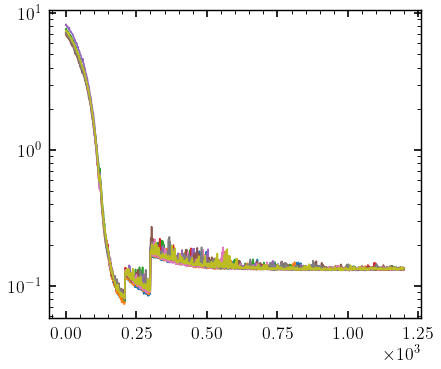

In [13]:
[plt.plot(NDE.train_loss_history) for NDE in np.array(NDE_list)[np.argsort(vali_loss)][:]]
plt.yscale('log')

# plt.axhline(0.26)
# plt.xlim(100)

In [14]:
torch.cuda.empty_cache()

### Show each NDE

In [15]:
from popsed.nde import transform_nmf_params, inverse_transform_nmf_params

from popsed.nde import inverse_transform_nmf_params_given_mass

In [16]:
_samples_unt = []
_samples = []
for NDE in [NDE_list[i] for i in np.argsort(vali_loss)[:]]:
    _samp = inverse_transform_nmf_params(NDE.sample(2000), _prior_NDE).cpu().detach().numpy()
    
    _samples_unt.append(_samp)
    _samples.append(np.hstack([_samp[:, -1:], 
                   prior.FlatDirichletPrior(4).transform(_samp[:, :3]), 
                   _samp[:, 3:-1]]))
_samples_unt = np.dstack(_samples_unt)
_samples = np.dstack(_samples)

In [17]:
# _spl = _samples_unt.swapaxes(0, 1).reshape(_samples_unt.shape[1], -1).T

In [18]:
# np.save('./NDE/GAMA/NMF/z_mass_mock.npy', _spl[:, -2:])

In [19]:
true_params_unt = np.load('./NDE/GAMA/NMF/mock_params_dr3apmatch_2.npy')
true_params_unt = true_params_unt[np.random.randint(0, len(true_params_unt), 10000)]
true_params = np.hstack([prior.FlatDirichletPrior(4).transform(true_params_unt[:, :3]),
                      true_params_unt[:, 3:-1], 
                      true_params_unt[:, -1:]])

In [20]:
import corner

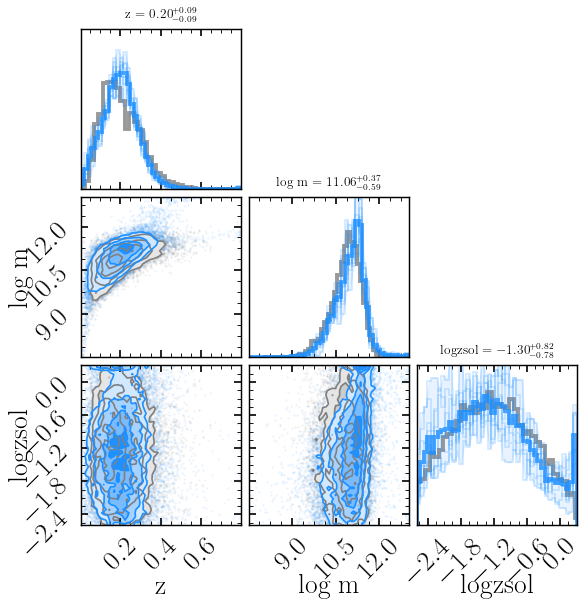

In [44]:
z_mass_met = np.hstack([true_params[:, -2:], true_params[:, 6:7]])
figure = corner.corner(z_mass_met,
                       labels=['z', 'log m', 'logzsol'], bins=45,
                       color='gray',  # quantiles=[0.16, 0.5, 0.84],
                       smooth=0.5, fill_contours=True,
                       scale_hist=False,
                       range=[[0, 1], [8, 13], [-3, 0.6]],
                       show_titles=True, title_kwargs={"fontsize": 12},
                       hist_kwargs={'density': True}, plot_datapoints=True)

figure = corner.corner(np.hstack([_samples_unt[:, -2:-1], _samples_unt[:, -1:], _samples_unt[:, 5:6]]),
                       fig=figure,
                       labels=['z', 'log m', 'logzsol'], bins=45,
                       color='dodgerblue',  # quantiles=[0.16, 0.5, 0.84],
                       smooth=0.5, fill_contours=True,
                       show_titles=True, title_kwargs={"fontsize": 12},
                       hist_kwargs={'density': True}, plot_datapoints=True)

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

In [22]:
import corner

In [21]:
import popsed
popsed.set_matplotlib(style='JL', usetex=True, dpi=80, fontsize=25)

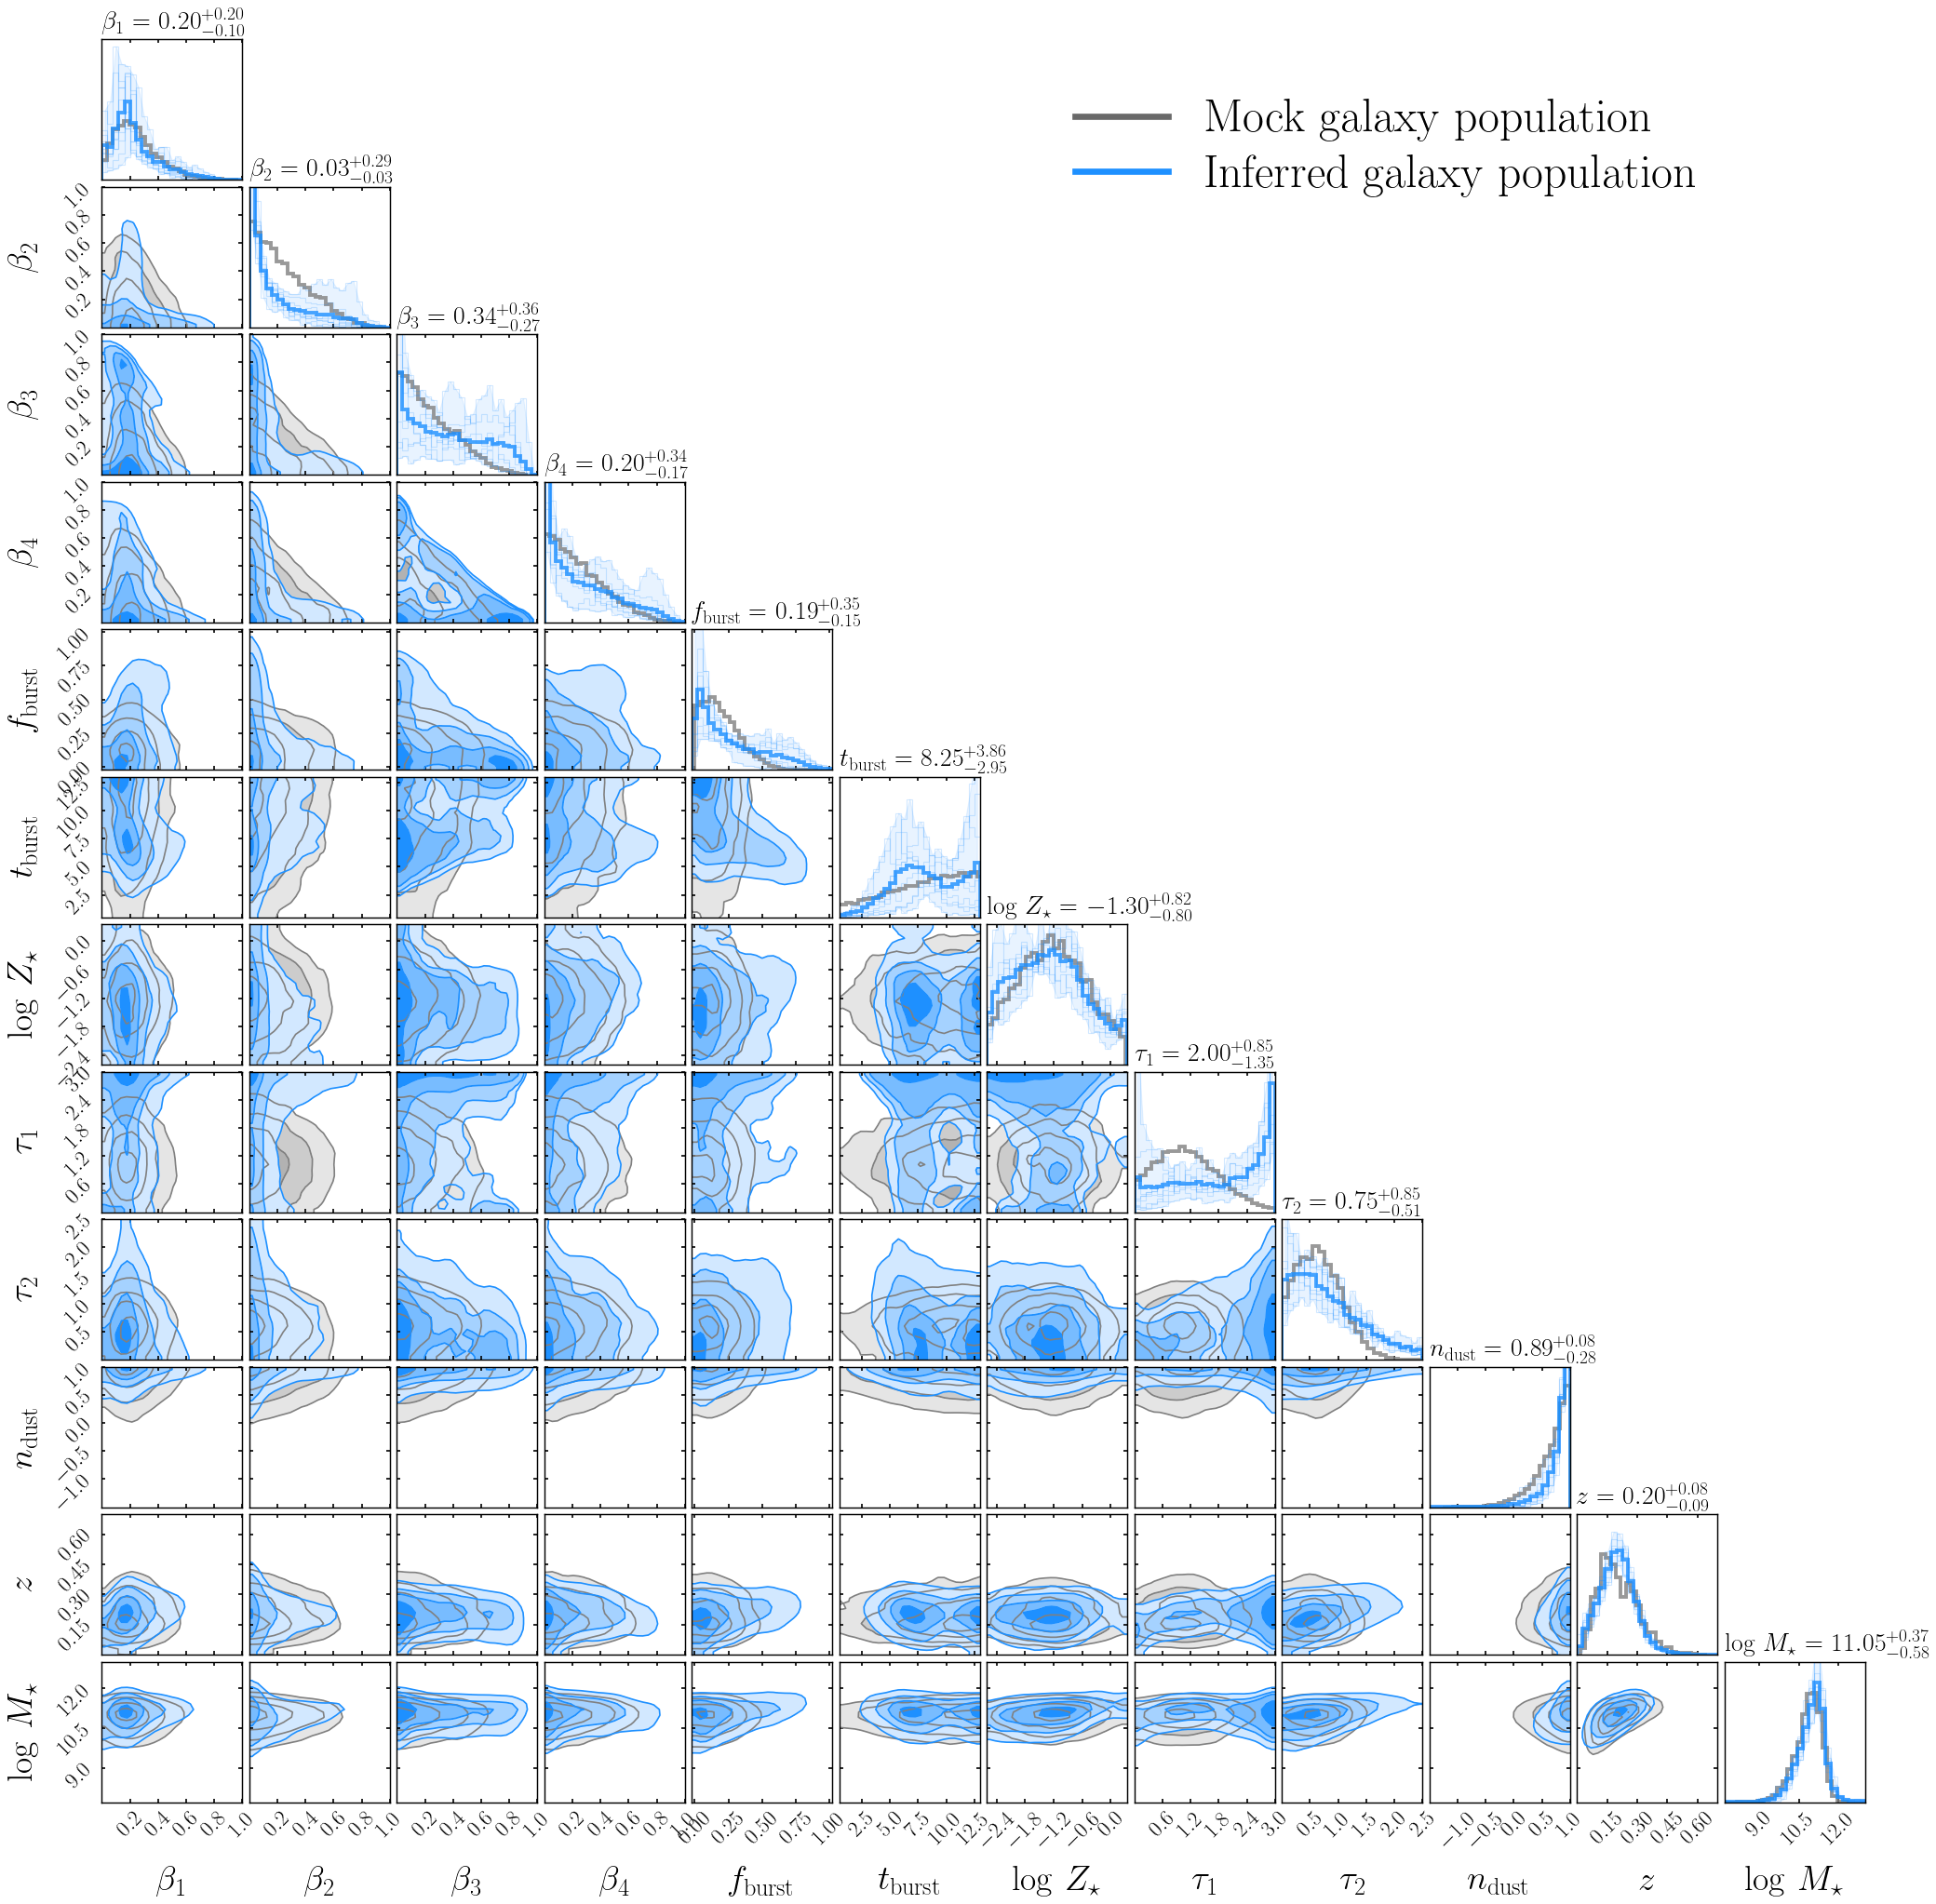

In [23]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], lw=6, color='dimgray',
                       label='Mock galaxy population')
b_line = mlines.Line2D([], [], color='dodgerblue', lw=6,
                       label=r'Inferred galaxy population')

labels = [
    r'$\beta_{1}$',
    r'$\beta_{2}$',
    r'$\beta_{3}$',
    r'$\beta_{4}$',
    r'$f_{\mathrm{burst}}$',
    r'$t_{\mathrm{burst}}$',
    r'$\log\,Z_\star$',
    r'$\tau_1$',
    r'$\tau_2$',
    r'$n_{\mathrm{dust}}$',
    r'$z$',
    r'$\log\,M_{\star}$',
]

if name == 'NMF_ZH':
    labels = labels[:6] + [r'$\gamma_{1}$', r'$\gamma_{2}$'] + labels[7:]


K = true_params.shape[1]
figure, axes = plt.subplots(K, K, figsize=(25, 25))

figure = corner.corner(true_params,
                       fig=figure,
                       yfactor=1.2,
                       labels=labels, bins=25,
                       color='gray', 
                       smooth=1.0, fill_contours=True,
                       show_titles=False, title_kwargs={"fontsize": 19},
                       hist_kwargs={'density': True}, plot_datapoints=False)

y_truth_trans = np.hstack([_samples[:, 1:],  # params taken by emulator, including redshift (for t_age)
                           _samples[:, 0:1],  # stellar mass
                           ])
figure = corner.corner(
    y_truth_trans,
    fig=figure,
    color='dodgerblue',
    yfactor=1.2,
    labels=labels,
    range=[[0, 1], [0, 1], [0., 1], [0, 1], [-0.02, 1.02], [0.5, 13],
           [-2.6, 0.35], [0, 3], [0, 2.5], [-1.5, 1], [0, 0.7], [7.7, 13]],
    bins=25,
    smooth=1.0,
    fill_contours=True,
    show_titles=True,
    title_kwargs={'fontsize': 25, 'loc': 'left'},
    label_kwargs={'fontsize': 34},
    labelpad=0.15,
    hist_kwargs={'density': True, 'lw': 1},
    plot_datapoints=False
)

for ax in figure.get_axes():
    ax.tick_params(labelsize=21, length=4)
    ax.minorticks_off()

ax = figure.get_axes()[10]
leg = ax.legend(handles=[k_line, b_line],
                fontsize=45,
                bbox_to_anchor=(0., 1.0, 1.3, .0))

# plt.suptitle(
#     'Tests on Mock Observation: SDSS $ugriz$-bands, GAMA DR3 noise', fontsize=40, y=1.02)
plt.savefig('/tigress/jiaxuanl/public_html/figure/popsed/mock_test_posterior.pdf',
            bbox_inches='tight')

In [41]:
# del _samples
# import gc
# gc.collect()

0 10000
>30 0
[11.8 11.8]


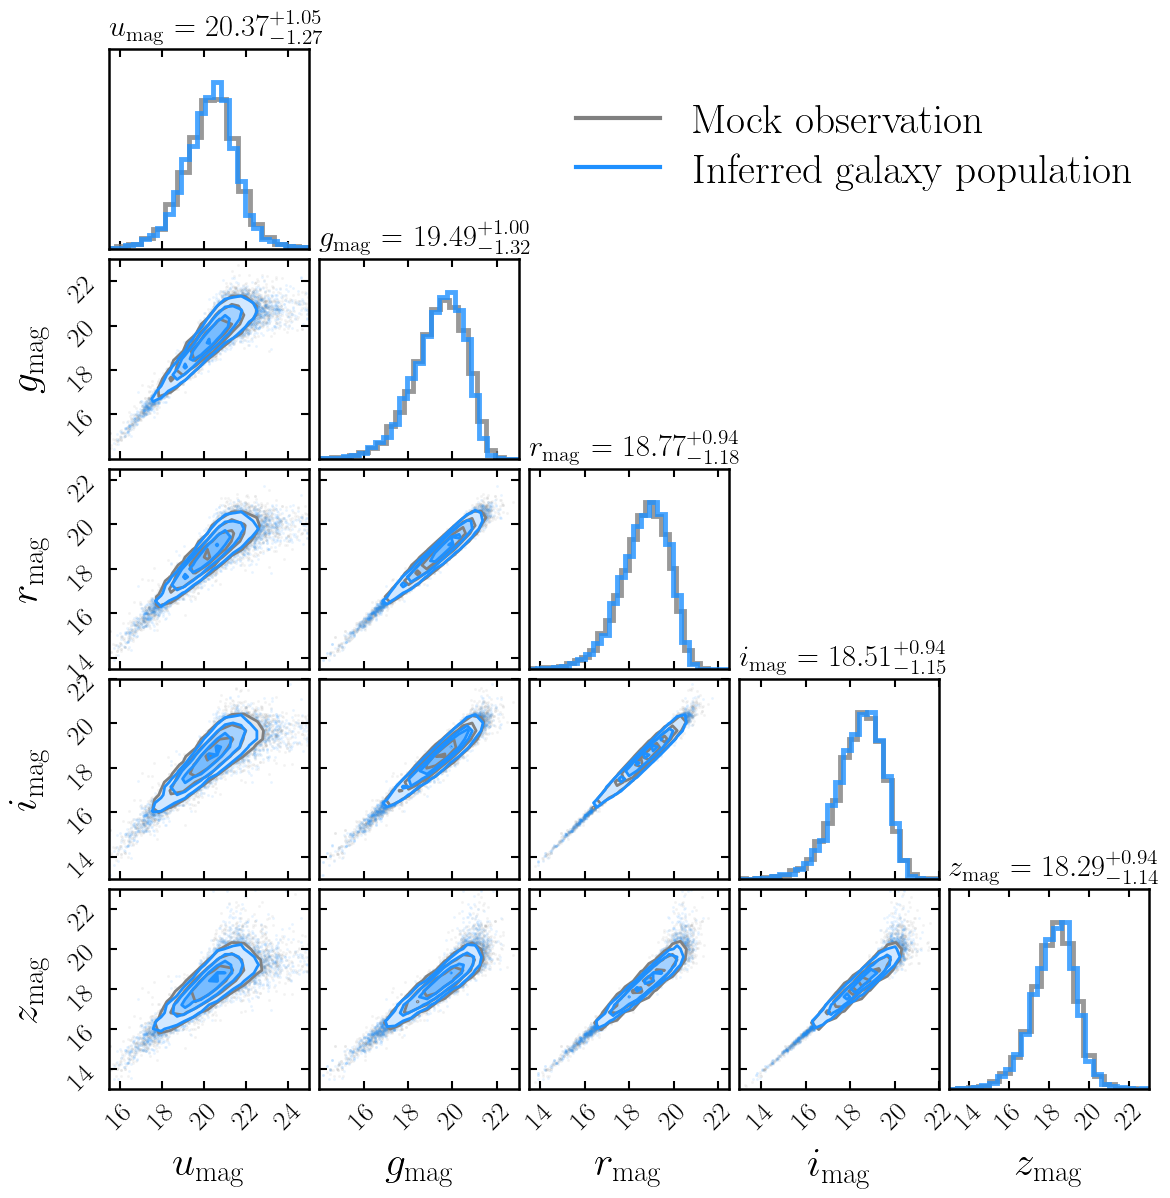

In [23]:
import popsed
popsed.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=25)
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1.8

import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='gray', lw=3, label='Mock observation')
b_line = mlines.Line2D([], [], color='dodgerblue', lw=3,
#                        label=r'Photometry of the inferred galaxy population')
                       label='Inferred galaxy population')

labels = [f'${filt}' + r'_{\rm mag}$' for filt in list('ugriz')]
#[filt.replace('_', '\_') for filt in gama_filters]

# Show mock data
figure = corner.corner(X_data[np.random.randint(0, len(X_data), 10000)],
                       color='gray', labels=labels, bins=25,
                       smooth=0.4, fill_contours=True,
                       show_titles=False, contour_kwargs={'linewidths': 2},
                       title_kwargs={"fontsize": 24},
                       hist_kwargs={'density': True})

# Show posterior in magnitude space
_spl = _samples_unt.swapaxes(0, 1).reshape(_samples_unt.shape[1], -1).T
_spl = torch.Tensor(_spl[np.random.randint(0, len(_spl), 10000)]).to('cuda')

mags = speculator._predict_mag_with_mass_redshift(_spl,
                                                  filterset=gama_filters,
                                                  noise=noise,
                                                  noise_model_dir=noise_model_dir,
                                                  SNR=1,
                                                  ).cpu().detach().numpy()
print(np.isnan(mags).any(axis=1).sum(), len(mags))
print('>30', np.any(mags > 30, axis=1).sum())
mags = mags[~(np.isinf(mags).any(axis=1)| np.isnan(mags).any(axis=1))]
mags = mags[~np.any(mags > 30, axis=1)]
figure = corner.corner(mags,
                       fig=figure, labels=labels, bins=25,
                       color='dodgerblue', 
                       smooth=0.4, fill_contours=True,
                       show_titles=True,
                       label_kwargs={"fontsize": 30},
                       title_kwargs={"fontsize": 22, 'loc': 'left'},
                       hist_kwargs={'density': True},
                       contour_kwargs={'linewidths': 2},
                       range=[[15.5, 25], [14, 23], [13.5, 22.5], [13, 22], [13, 23]])

for ax in figure.get_axes():
    ax.tick_params(labelsize=20)#, length=4)
    ax.minorticks_off()
    
ax = figure.get_axes()[4]
leg = ax.legend(handles=[k_line, b_line],
                fontsize=30,
                bbox_to_anchor=(0., 1.0, 1.2, .0))
print(figure.get_size_inches())

plt.tight_layout()
# plt.savefig('/tigress/jiaxuanl/public_html/figure/popsed/mock_test_photometry.pdf', 
#             bbox_inches='tight')

[11.8 11.8]


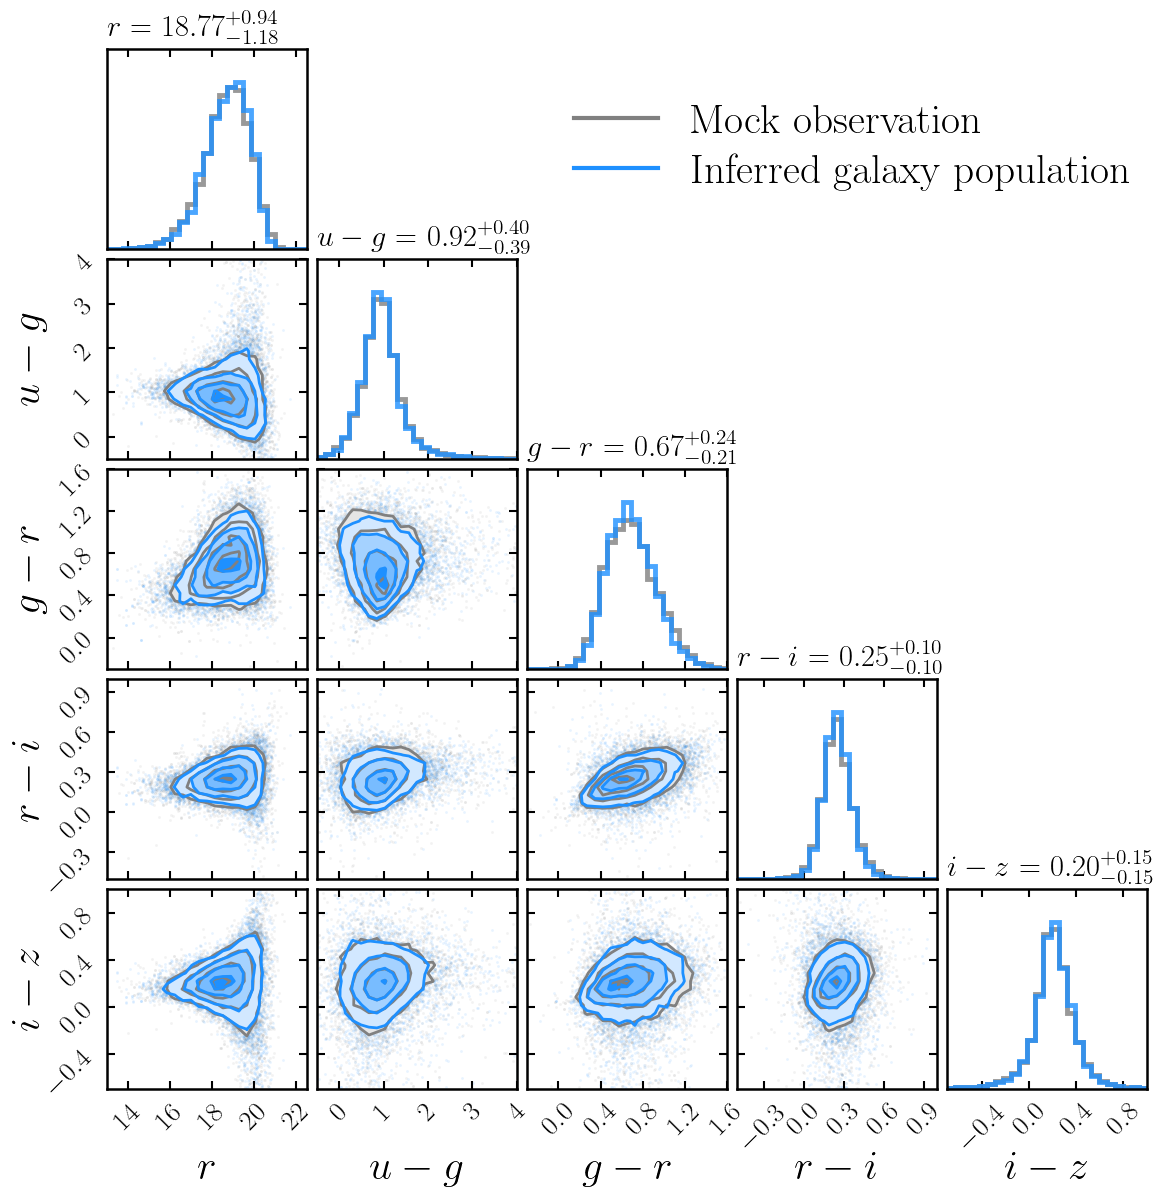

In [26]:
import popsed
popsed.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=25)
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1.8

import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='gray', lw=3, label='Mock observation')
b_line = mlines.Line2D([], [], color='dodgerblue', lw=3,
                       label='Inferred galaxy population')


# labels = [f'${filt}' + r'_{\rm mag}$' for filt in list('ugriz')]
labels = [r'$r$', r'$u - g$', r'$g - r$',
          r'$r - i$', r'$i - z$']
# Show mock data
temp = np.vstack([X_data[:, 2], X_data[:, 0]-X_data[:, 1], 
                  X_data[:, 1]-X_data[:, 2], X_data[:, 2]-X_data[:, 3], 
                  X_data[:, 3]-X_data[:, 4]]).T
figure = corner.corner(temp[np.random.randint(0, len(temp), 10000)],
                       color='gray', labels=labels, bins=25,
                       smooth=0.35, fill_contours=True,
                       show_titles=False, contour_kwargs={'linewidths': 2},
                       title_kwargs={"fontsize": 24},
                       hist_kwargs={'density': True},
                       range=[[13., 22.5], [-0.5, 4], [-0.3, 1.6], [-0.5, 1], [-0.7, 1.]]
                      )

# Show posterior in magnitude space
temp = np.vstack([mags[:, 2], mags[:, 0]-mags[:, 1], 
                  mags[:, 1]-mags[:, 2], mags[:, 2]-mags[:, 3], 
                  mags[:, 3]-mags[:, 4]]).T
figure = corner.corner(temp,
                       fig=figure, labels=labels, bins=25,
                       color='dodgerblue', 
                       smooth=0.4, fill_contours=True,
                       show_titles=True,
                       label_kwargs={"fontsize": 30},
                       title_kwargs={"fontsize": 22, 'loc': 'left'},
                       hist_kwargs={'density': True},
                       contour_kwargs={'linewidths': 2},
                       range=[[13., 22.5], [-0.5, 4], [-0.3, 1.6], [-0.5, 1], [-0.7, 1.]]
#                        range=[[15.5, 25], [14, 23], [13.5, 22.5], [13, 22], [13, 23]]
                      )

for ax in figure.get_axes():
    ax.tick_params(labelsize=20)#, length=4)
    ax.minorticks_off()
    
ax = figure.get_axes()[4]
leg = ax.legend(handles=[k_line, b_line],
                fontsize=30,
                bbox_to_anchor=(0., 1.0, 1.2, .0))
print(figure.get_size_inches())

plt.tight_layout()
plt.savefig('/tigress/jiaxuanl/public_html/figure/popsed/mock_test_photometry_color.pdf', 
            bbox_inches='tight')

---
### Calculate average age and SFR, compare with the ground truth

In [20]:
from popsed.utils import calc_observables

In [21]:
obs_recs = []
for i in range(_samples.shape[2]): # 
    params = _samples[..., i]
    obs_recs.append(calc_observables(params, name, dt=0.1))

Initialize NMF-based SPS model
Input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index
Initialize NMF-based SPS model
Input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index
Initialize NMF-based SPS model
Input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index
Initialize NMF-based SPS model
Input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index
Initialize NMF-based SPS model
Input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index
Initialize NMF-based SPS model
Input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index
Initialize NMF-based SPS model
Input parameters : logmstar, beta1_sfh, beta2

In [22]:
obs_rec = {}
for k in obs_recs[0].keys():
    obs_rec[k] = np.array(tuple(d[k] for d in obs_recs))

In [23]:
obs_rec['logmstar'].shape

(9, 2000)

In [24]:
temp = np.hstack([obs_rec['logmstar'].T.reshape(2000, -1, _samples.shape[2]), 
                  obs_rec['redshift'].T.reshape(2000, -1, _samples.shape[2]),
                  np.log10(obs_rec['sfr'].T.reshape(2000, -1, _samples.shape[2])),
                  obs_rec['logzsol'].T.reshape(2000, -1, _samples.shape[2]),
                  obs_rec['age'].T.reshape(2000, -1, _samples.shape[2])])

In [25]:
temp.shape

(2000, 5, 9)

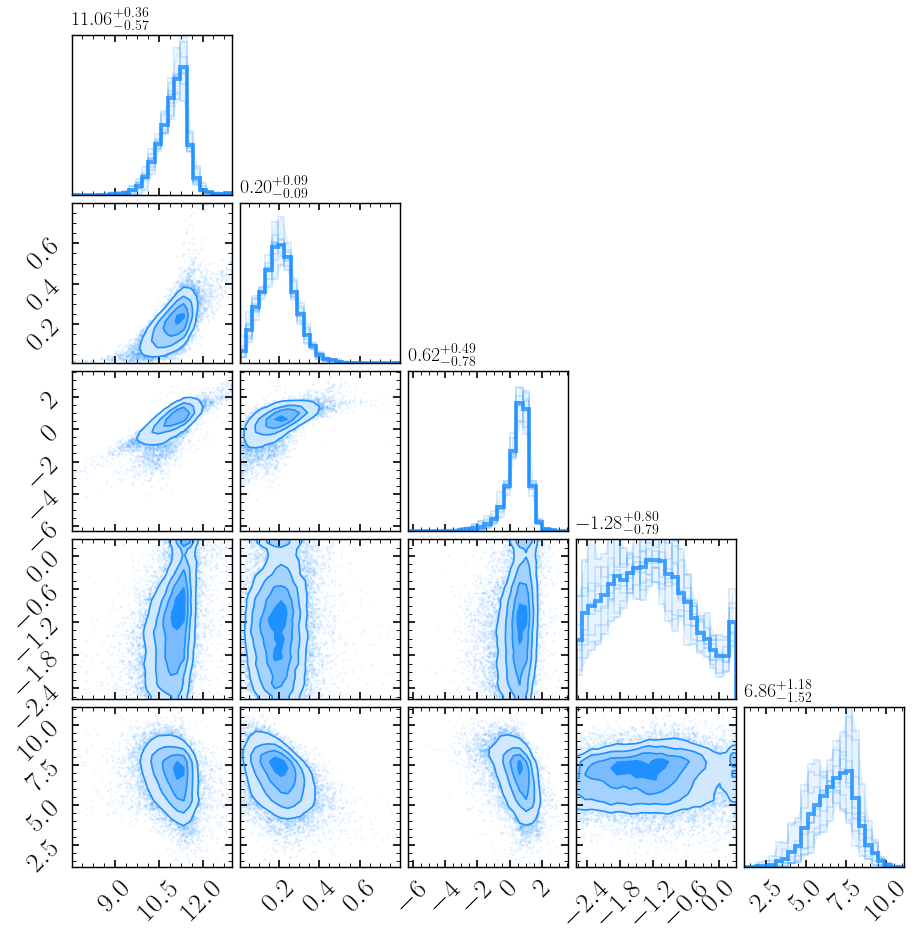

In [32]:
corner.corner(temp, bins=25,
                       color='dodgerblue',  # quantiles=[0.16, 0.5, 0.84],
                       smooth=0.6, fill_contours=True,
                       show_titles=True, title_kwargs={"fontsize": 18, 'loc': 'left'},
                       hist_kwargs={'density': True}, plot_datapoints=True);

In [27]:
# True parameters
params = np.hstack([true_params[:, -1:], true_params[:, :-1]])
params = torch.Tensor(params[np.random.randint(0, len(params), 5000)]).detach().cpu().numpy()
obs_truth = calc_observables(params, name, dt=0.1)

Initialize NMF-based SPS model
Input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index


Text(0, 0.5, 'SFR [Gyr$^{-1}$]')

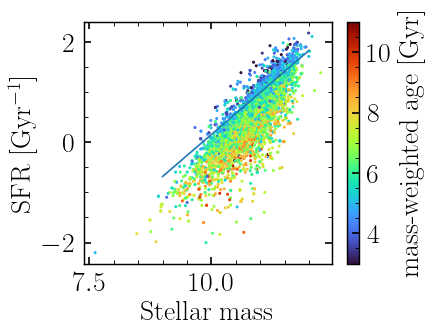

In [205]:
fig, ax = plt.subplots(figsize=(5, 4))

plt.scatter(obs_truth['logmstar'], np.log10(obs_truth['sfr']), 
            c=obs_truth['age'], s=3, vmin=3, vmax=11)

x = np.linspace(9, 12)
plt.plot(x, 0.84 * (x - 10.5) + 0.58)

# plt.xlim(9, 12.3)
# plt.ylim(-13, -8)

plt.colorbar(label='mass-weighted age [Gyr]')
plt.xlabel('Stellar mass')
plt.ylabel('SFR [Gyr$^{-1}$]')

Text(0, 0.5, 'SFR [Gyr$^{-1}$]')

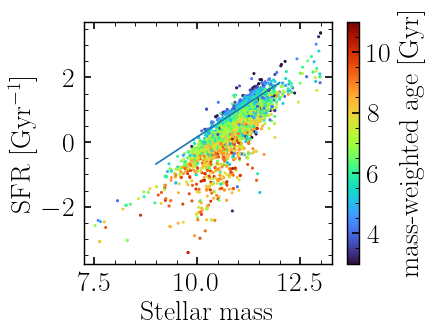

In [206]:
fig, ax = plt.subplots(figsize=(5, 4))

plt.scatter(obs_rec['logmstar'], np.log10(obs_rec['sfr']), 
            c=obs_rec['age'], s=3, vmin=3, vmax=11)

x = np.linspace(9, 12)
plt.plot(x, 0.84 * (x - 10.5) + 0.58)

# plt.xlim(9, 12.3)
# plt.ylim(-13, -8)

plt.colorbar(label='mass-weighted age [Gyr]')
plt.xlabel('Stellar mass')
plt.ylabel('SFR [Gyr$^{-1}$]')

In [28]:
import popsed
popsed.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=25)
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1.8

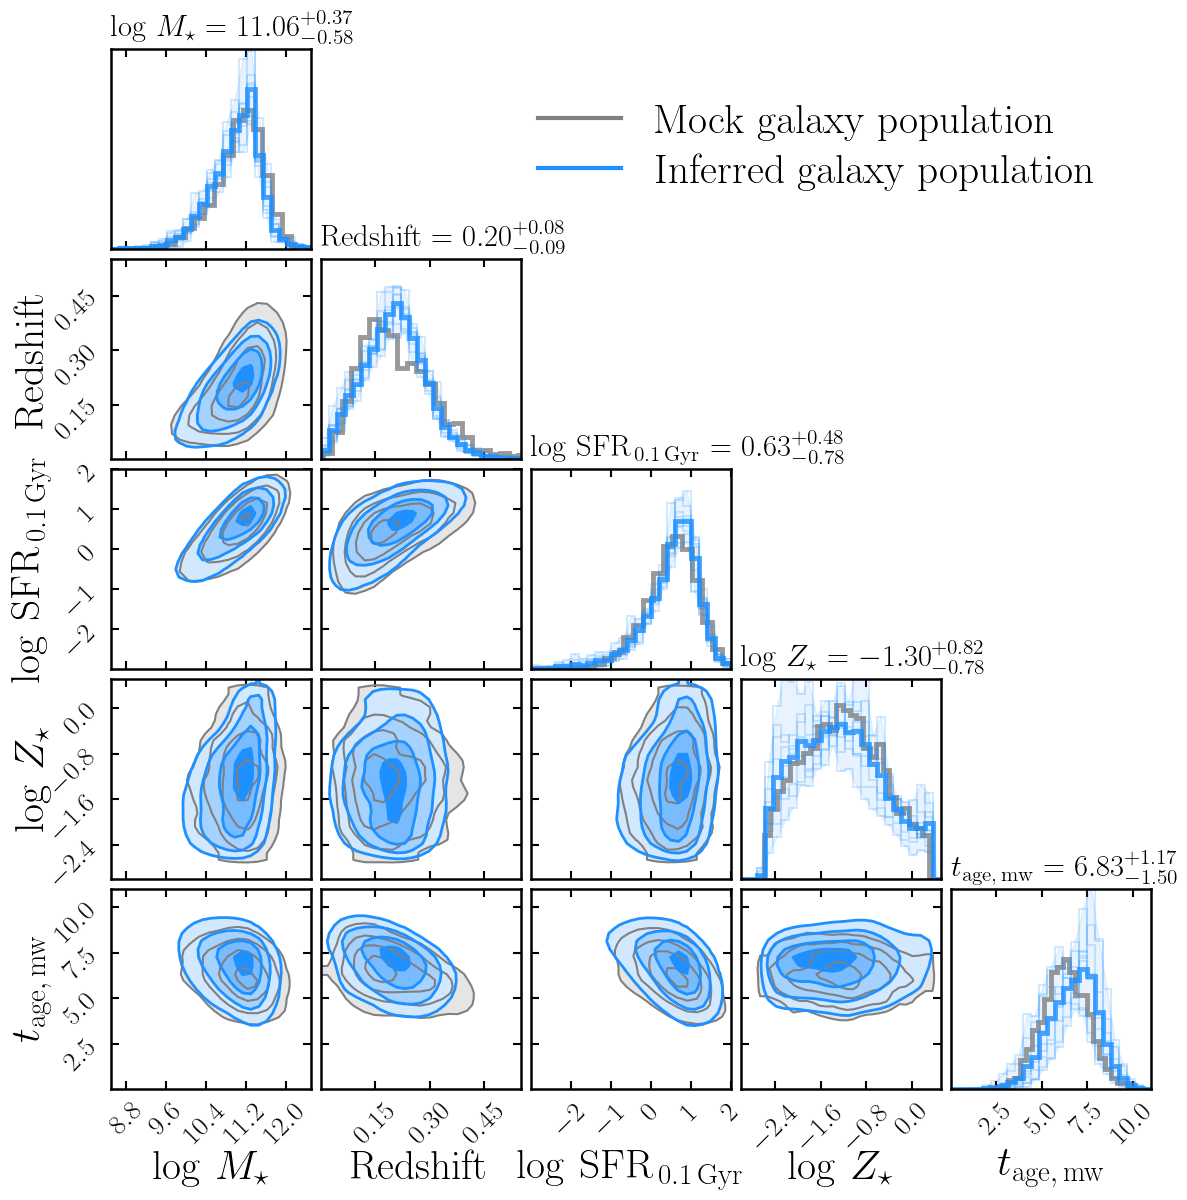

In [34]:
labels = [r'$\log\,M_{\star}$', r'Redshift', r'$\log\,\mathrm{SFR}_{\,0.1\,\rm Gyr}$', 
          r'$\log\,Z_{\star}$', r'$t_{\mathrm{age,\,mw}}$']

figure = corner.corner(np.vstack([obs_truth['logmstar'] + 0.2, obs_truth['redshift'],
                                  np.log10(obs_truth['sfr']), obs_truth['logzsol'], obs_truth['age']]).T,
                       labels=labels, bins=25,
                       color='gray',  # quantiles=[0.16, 0.5, 0.84],
                       smooth=1, fill_contours=True,
                       show_titles=False, title_kwargs={"fontsize": 14},
                       hist_kwargs={'density': True}, plot_datapoints=False)

figure = corner.corner(temp,
#                     np.vstack([obs_rec['logmstar'], obs_rec['redshift'],
#                                   np.log10(obs_rec['sfr']), obs_rec['logzsol'], obs_rec['age']]).T,
                       fig=figure,
                       labels=labels, bins=25,
                       color='dodgerblue',  # quantiles=[0.16, 0.5, 0.84],
                       smooth=1, fill_contours=True,
                       show_titles=True, 
                       label_kwargs={"fontsize": 30},
                       title_kwargs={"fontsize": 22, 'loc': 'left'},
                       hist_kwargs={'density': True},
                       contour_kwargs={'linewidths': 2},
                       plot_datapoints=False,
                       range=[[8.5, 12.5], [0, 0.55], [-3, 2], [-3., 0.5], [0, 11]])

import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='gray', lw=3, label='Mock galaxy population')
b_line = mlines.Line2D([], [], color='dodgerblue', lw=3,
                       label=r'Inferred galaxy population')

for ax in figure.get_axes():
    ax.tick_params(labelsize=20)#, length=4)
    ax.minorticks_off()
    
ax = figure.get_axes()[4]
leg = ax.legend(handles=[k_line, b_line],
                fontsize=30,)

plt.savefig('/tigress/jiaxuanl/public_html/figure/popsed/mock_test_params.pdf', 
            bbox_inches='tight',)

In [28]:
def speagle_MS(z, x):
    from astropy.cosmology import Planck15
    age = Planck15.age(z).value
    return (0.84 - 0.026 * age) * x - (6.51 - 0.11 * age)

In [29]:
flag = (obs_rec['redshift'] < 0.3)

Text(0, 0.5, 'SFR [$M_\\odot$ yr$^{-1}$]')

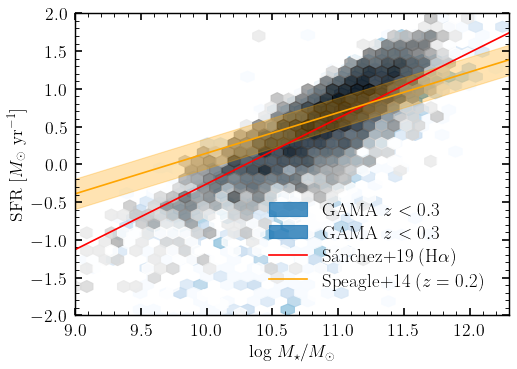

In [32]:
fig, ax = plt.subplots(figsize=(7, 5))

plt.hexbin(obs_rec['logmstar'][flag], np.log10(obs_rec['sfr'][flag]), 
           gridsize=50, cmap='Blues', bins='log', label=r'GAMA $z<0.3$', alpha=0.8)

plt.hexbin(obs_truth['logmstar'][flag], np.log10(obs_truth['sfr'][flag]), 
           gridsize=50, cmap='Greys', bins='log', label=r'GAMA $z<0.3$', alpha=0.8)

# plt.scatter(obs_rec['logmstar'][flag], np.log10(obs_rec['sfr'][flag]), s=1, alpha=0.1)

x = np.linspace(9, 12.5)
plt.plot(x, 0.87 * (x) - 8.96, color='r', label=r'S\'anchez+19 (H$\alpha$)')

z = 0.17
plt.plot(x, speagle_MS(z, x), color='orange', alpha=1, label=r'Speagle+14 ($z=0.2$)')
plt.fill_between(x, speagle_MS(z, x) + 0.2, speagle_MS(z, x) - 0.2, color='orange', alpha=0.3)

plt.xlim(9, 12.3)
plt.ylim(-2, 2)

plt.legend(fontsize=17)
# plt.colorbar(label='mass-weighted age [Gyr]')
plt.xlabel(r'$\log\,M_\star/M_\odot$')
plt.ylabel('SFR [$M_\odot$ yr$^{-1}$]')

# plt.savefig('/tigress/jiaxuanl/public_html/figure/popsed/gama_dr3_sfms.pdf', 
#             bbox_inches='tight')

---

In [159]:
logmstar = _spl[:, 0]
logzsol = _spl[:, 7]
u_r = mags[:, 0] - mags[:, 2]

Text(0, 0.5, 'sSFR [Gyr$^{-1}$]')

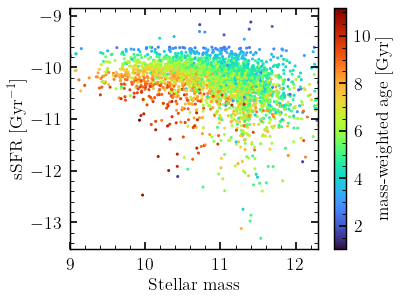

In [129]:
fig, ax = plt.subplots(figsize=(5, 4))

plt.scatter(logmstar, np.log10(sfr) - logmstar, c=age, s=3)

plt.xlim(9, 12.3)
# plt.ylim(-13, -8)

plt.colorbar(label='mass-weighted age [Gyr]')
plt.xlabel('Stellar mass')
plt.ylabel('sSFR [Gyr$^{-1}$]')

Text(0, 0.5, 'Age [Gyr]')

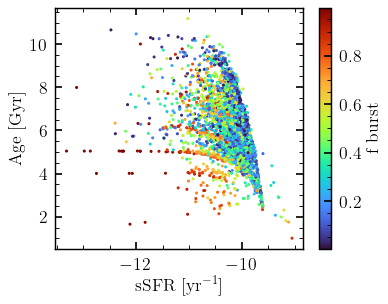

In [150]:
fig, ax = plt.subplots(figsize=(5, 4))

plt.scatter(np.log10(sfr) - logmstar, age, c=_spl[:, 5], s=3)

# plt.xlim(9, 12.3)
# plt.ylim(-13, -8)

plt.colorbar(label='f burst')
plt.xlabel('sSFR [yr$^{-1}$]')
plt.ylabel('Age [Gyr]')

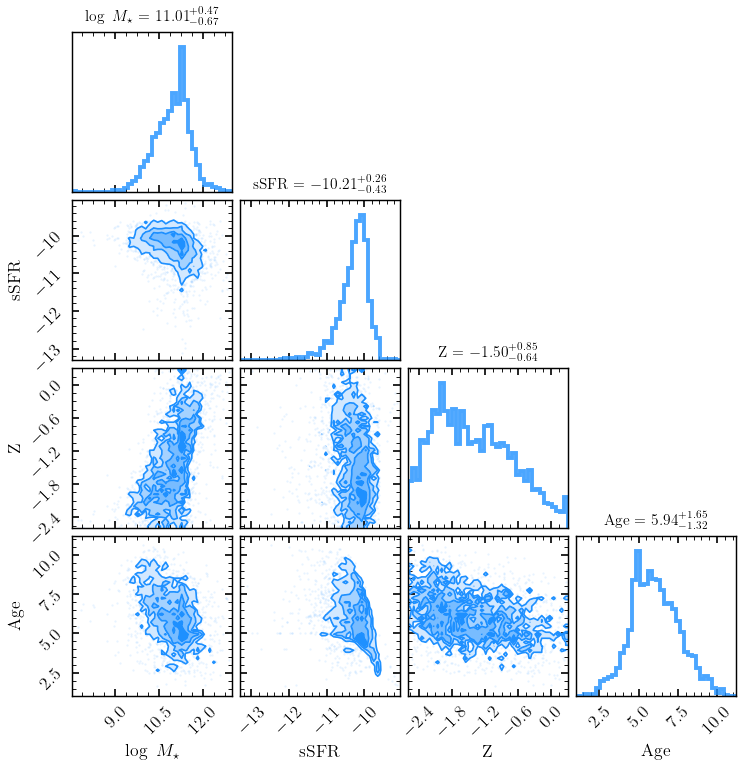

In [161]:
figure = corner.corner(np.vstack([logmstar, np.log10(sfr)-logmstar, logzsol, age]).T, 
                  labels=['$\log\ M_\star$', 'sSFR', 'Z', 'Age'], bins=40,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.3, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 14}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

# ax = figure.get_axes()[2]
# ax.legend(handles=[k_line, b_line], fontsize=17, bbox_to_anchor=(0., 1.0, 1.3, .0))

# plt.suptitle('GAMA DR3 aperture-matched photometry, SDSS $ugriz$', y=1.06)

In [29]:
tt = _samples[..., 0][0:1]
tage = model.cosmo.age(tt[:, -1:]).value # convert redshift to age
theta = model._parse_theta(tt[:, :-1])

Text(0, 0.5, 'SFR [Msun/yr] (normalized to 1 Msun)')

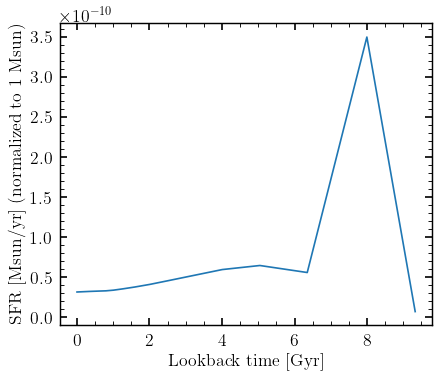

In [37]:
# Display SFH
tlb_edges, sfh = model.SFH(np.hstack([np.zeros(len(tt))[:, None], tt[:, 1:-1]]), zred=tt[:, -1][0], _burst=True)
plt.plot(0.5 * (tlb_edges[1:] + tlb_edges[:-1]), sfh)
plt.xlabel('Lookback time [Gyr]')
plt.ylabel('SFR [Msun/yr] (normalized to 1 Msun)')

In [73]:
sfrs = []
for tt in _samples[..., 0][0:1000]:
    sfrs.append(model.avgSFR(tt[:-1], zred=tt[-1], dt=1))
    
sfrs = np.array(sfrs).ravel()

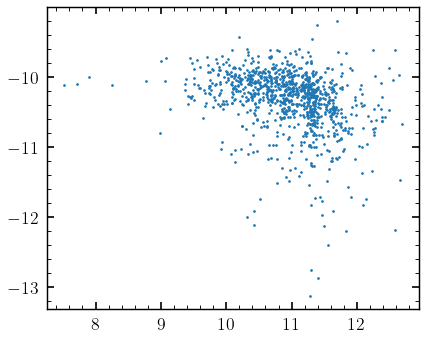

In [79]:
plt.scatter(_samples[..., 0][0:1000][:, 0], np.log10(sfrs) - _samples[..., 0][0:1000][:, 0], s=2)

In [80]:
model.tage_MW(tt[:-1], zred=tt[-1])

array([5.01615946])